In [1]:
import pandas as pd
import pymongo
import datetime
import time
import yfinance as yf
import os
from matplotlib import pyplot as plt

import csv
import requests

In [2]:
dic = {'公司代號':'Number', '股票代號':'Number', '證券代號':'Number', '股票名稱':'Name', '證券名稱':'Name', '收盤價':'Price', '月平均價':'Price_month',
      '成交股數':'Quantity', '開盤價':'Start', '最高價':'High', '最低價':'Low', '漲跌價差':'Spread'}

In [3]:
def Start_date(days = 365):
    date = datetime.datetime.now()
    d = datetime.timedelta(days)
    start_date = date - d
    date = date.strftime("%Y-%m-%d")
    start_date = start_date.strftime("%Y-%m-%d")
    return start_date

date = time.strftime("%Y-%m-%d")
start_date = Start_date()
print(date, start_date)

2022-12-31 2021-12-31


In [4]:
def Plot(stock_no = '2330', start_date = start_date, saving = False):
    # dataframe
    stock_no += '.TW' 
    df = yf.download(stock_no, start = start_date)
    df = df.reset_index()
    print(df)
    
    # plot
    ax = plt.gca()
    df.plot(kind='line',x='Date',y='High',ax=ax)
    df.plot(kind='line',x='Date',y='Low', color='red', ax=ax)
    plt.title(stock_no)
    if saving == True:
        save_dir = 'plot/'+date+'/'
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        plt.savefig('plot/'+date+'/'+stock_no+'.png')
    plt.show()


In [5]:
CSV_URL = 'https://mopsfin.twse.com.tw/opendata/t187ap03_L.csv'

def Download_csv(url = CSV_URL):
    with requests.Session() as s:
        download = s.get(url)
        decoded_content = download.content.decode('utf-8')
        cr = csv.reader(decoded_content.splitlines(), delimiter=',')
        my_list = list(cr)
        df = pd.DataFrame(my_list)
        new_header = df.iloc[0]
        df = df[1:]
        df.columns = new_header
        return df


In [15]:
# mongo DB
def Convert2dict(data):
    data.reset_index(inplace=True)
    Data_dictionary = data.to_dict('records') # 'dataframe'
    return Data_dictionary

def Link2db(url, db_n, collection_n):
    client = pymongo.MongoClient(url)  
    db = client[db_n]
    collection = db[collection_n]
    dblist = client.list_database_names()
    print(dblist)
    return collection

def Readdb(collection, col = '', reverse = False, days = 0): # False = big to small
    data_db = collection.find()
    df = pd.DataFrame(list(data_db))
    if days != 0:
        mask = df['Date'] > Start_date(days)
        df = df.loc[mask]
    if col != '':     
        df = df.sort_values(by=[col], ascending=reverse)
    return df
    
def Insert(collection, data, check=True): # Insert data
    df = Readdb(collection)
    start = time.time()
    if df.empty:
        data = Convert2dict(data)
        collection.insert_many(data)
        print('Insert to database')
    elif check:
        if data['Date'].iloc[-1] not in df['Date'].iloc[-1]:
            data = Convert2dict(data)
            collection.insert_many(data)
            print('Insert to database')
    end = time.time()
    print(end-start,'seconds')

def Update(collection):
    myquery = { "Number": { "$regex": "^0" } }
    newvalues = { "$set": { "Del": 'True' } }
    start = time.time()
    x = collection.update_many(myquery, newvalues, upsert = True)
    end = time.time()
    print(x.modified_count, "update")
    print(end-start,'seconds')
    
def Delete(collection):
    myquery = { "Del": 'True' }
    start = time.time()
    x = collection.delete_many(myquery)
    end = time.time()
    print(x.deleted_count,'delete')
    print(end-start,'seconds')


In [7]:
data_price = Download_csv('https://www.twse.com.tw/exchangeReport/STOCK_DAY_AVG_ALL?response=open_data') # https://data.gov.tw/dataset/11548
data_price.rename(columns = dic, inplace = True)
data_price.insert(0,'Date',date)
#print(data_price)
collect = Link2db('mongodb://localhost:27017/', 'Test', 'Price')
Insert(collect, data_price)
Update(collect)
Delete(collect)
Readdb(collect)

['Test', 'admin', 'config', 'local']
0.0 seconds
0 update
0.0039048194885253906 seconds
1 delete
0.0029294490814208984 seconds


,_id,index,Date,Number,Name,Price,Price_month
0,63aff7177a47501350c190f7,19743,2022-12-31,1101,台泥,33.65,33.85
1,63aff7177a47501350c190f8,19744,2022-12-31,1101B,台泥乙特,47.10,47.97
2,63aff7177a47501350c190f9,19745,2022-12-31,1102,亞泥,41.00,41.16
3,63aff7177a47501350c190fa,19746,2022-12-31,1103,嘉泥,17.40,17.68
4,63aff7177a47501350c190fb,19747,2022-12-31,1104,環泥,22.20,22.38
...,...,...,...,...,...,...,...
6025,63b0011e7a47501350c32ed3,20743,2022-12-31,9944,新麗,20.45,20.47
6026,63b0011e7a47501350c32ed4,20744,2022-12-31,9945,潤泰新,43.25,44.47
6027,63b0011e7a47501350c32ed5,20745,2022-12-31,9946,三發地產,12.20,12.25
6028,63b0011e7a47501350c32ed6,20746,2022-12-31,9955,佳龍,19.80,20.60


['Test', 'admin', 'config', 'local']
0.0 seconds
0 update
0.0019583702087402344 seconds
1 delete
0.0009741783142089844 seconds
5607
[*********************100%***********************]  1 of 1 completed
          Date       Open       High        Low      Close  Adj Close   Volume
0   2022-01-03  67.500000  67.800003  64.800003  65.199997  63.103111  1502382
1   2022-01-04  64.500000  64.500000  62.599998  63.799999  61.748138  2342611
2   2022-01-05  63.599998  65.900002  63.500000  65.000000  62.909546   903331
3   2022-01-06  64.500000  67.300003  64.500000  66.800003  64.651657  1030456
4   2022-01-07  67.500000  68.599998  66.300003  67.800003  65.619499  1554719
..         ...        ...        ...        ...        ...        ...      ...
241 2022-12-26  50.400002  51.000000  50.200001  50.400002  50.400002   243017
242 2022-12-27  50.900002  51.500000  50.599998  50.900002  50.900002   377000
243 2022-12-28  50.500000  51.200001  50.200001  50.200001  50.200001   302021
244 2022-

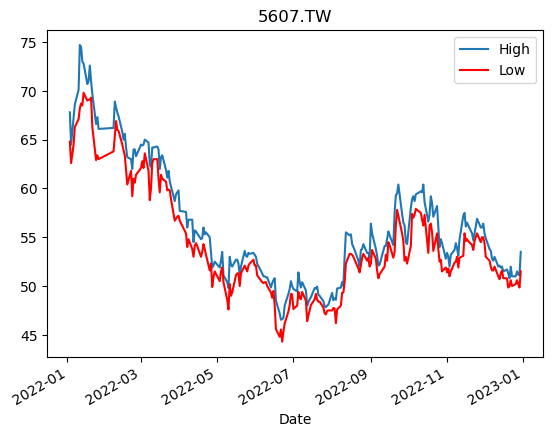

3164
[*********************100%***********************]  1 of 1 completed
          Date       Open       High        Low      Close  Adj Close   Volume
0   2022-01-03  24.500000  24.799999  24.350000  24.450001  23.382738   187260
1   2022-01-04  24.450001  24.549999  24.250000  24.549999  23.478373    93079
2   2022-01-05  24.500000  24.900000  24.500000  24.650000  23.574007   229001
3   2022-01-06  24.650000  24.700001  24.549999  24.650000  23.574007    50230
4   2022-01-07  24.549999  24.650000  24.350000  24.600000  23.526190    54165
..         ...        ...        ...        ...        ...        ...      ...
241 2022-12-26  25.350000  26.500000  25.049999  25.400000  25.400000  1064053
242 2022-12-27  25.600000  25.600000  24.400000  24.549999  24.549999   449000
243 2022-12-28  24.450001  24.900000  24.100000  24.100000  24.100000   187042
244 2022-12-29  24.100000  24.250000  23.700001  23.700001  23.700001   203000
245 2022-12-30  23.799999  23.950001  23.600000  23.70000

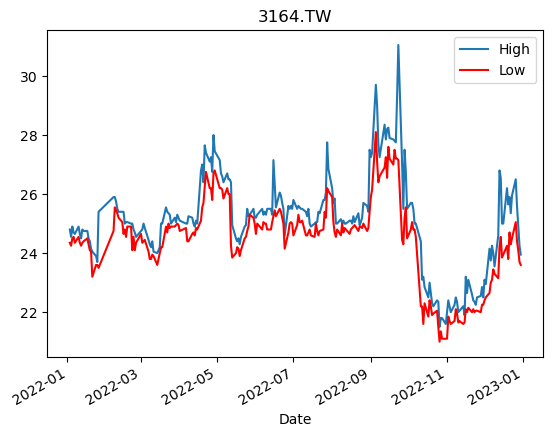

6278
[*********************100%***********************]  1 of 1 completed
          Date        Open        High         Low       Close   Adj Close  \
0   2022-01-03  126.500000  131.000000  124.000000  124.000000  114.893509   
1   2022-01-04  125.500000  127.000000  124.000000  126.500000  117.209915   
2   2022-01-05  127.000000  131.000000  125.500000  131.000000  121.379433   
3   2022-01-06  129.000000  133.000000  127.000000  133.000000  123.232559   
4   2022-01-07  133.000000  135.500000  130.000000  133.500000  123.695839   
..         ...         ...         ...         ...         ...         ...   
241 2022-12-26   92.000000   93.000000   91.800003   92.099998   92.099998   
242 2022-12-27   92.199997   94.000000   92.099998   93.599998   93.599998   
243 2022-12-28   92.699997   92.800003   90.000000   90.099998   90.099998   
244 2022-12-29   89.300003   90.099998   88.599998   90.000000   90.000000   
245 2022-12-30   90.900002   91.000000   89.000000   89.000000   89.

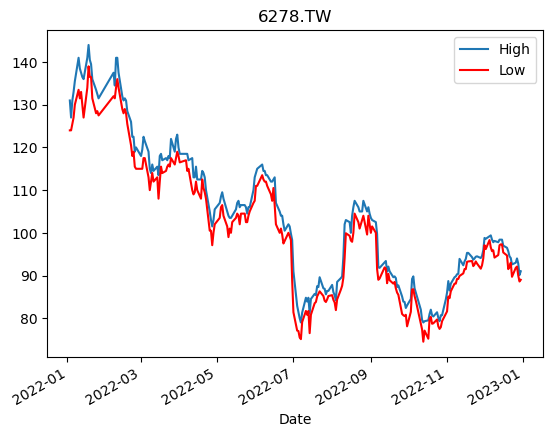

2012
[*********************100%***********************]  1 of 1 completed
          Date       Open       High        Low      Close  Adj Close  Volume
0   2022-01-03  29.523809  30.000000  29.000000  29.095238  27.607964  390706
1   2022-01-04  29.142857  29.142857  28.857141  29.047619  27.562778  161288
2   2022-01-05  28.857141  29.380953  28.857141  29.047619  27.562778  182752
3   2022-01-06  29.190475  29.190475  28.857141  28.904760  27.427223  173302
4   2022-01-07  29.285713  29.285713  28.380953  28.523809  27.065746  344901
..         ...        ...        ...        ...        ...        ...     ...
241 2022-12-26  24.049999  24.100000  23.850000  23.950001  23.950001   55152
242 2022-12-27  23.900000  23.950001  23.850000  23.850000  23.850000   56150
243 2022-12-28  23.900000  23.900000  23.700001  23.700001  23.700001  526101
244 2022-12-29  23.700001  23.700001  23.350000  23.450001  23.450001   87418
245 2022-12-30  23.650000  24.049999  23.549999  24.000000  24.00000

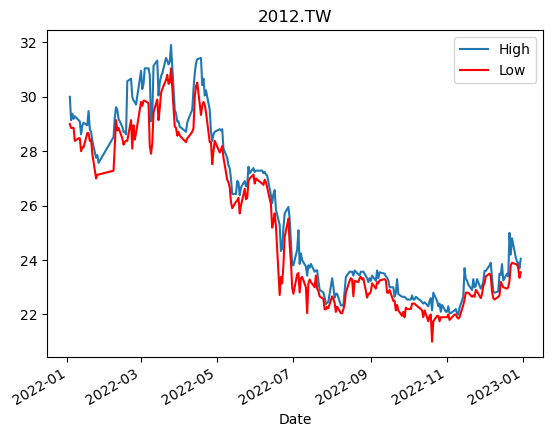

2520
[*********************100%***********************]  1 of 1 completed
          Date       Open       High        Low      Close  Adj Close   Volume
0   2022-01-03  37.900002  37.900002  37.599998  37.700001  34.558334   900290
1   2022-01-04  37.700001  37.750000  37.450001  37.549999  34.420834  1086702
2   2022-01-05  37.500000  37.700001  37.299999  37.450001  34.329166  1065640
3   2022-01-06  37.349998  37.450001  37.200001  37.299999  34.191666  1362250
4   2022-01-07  37.299999  37.450001  36.750000  36.900002  33.825001  1667422
..         ...        ...        ...        ...        ...        ...      ...
241 2022-12-26  28.750000  28.900000  28.600000  28.600000  28.600000   294223
242 2022-12-27  28.700001  28.850000  28.549999  28.700001  28.700001   267421
243 2022-12-28  28.750000  28.750000  28.500000  28.500000  28.500000   305701
244 2022-12-29  28.350000  29.000000  28.200001  28.900000  28.900000   889206
245 2022-12-30  28.900000  29.350000  28.750000  29.20000

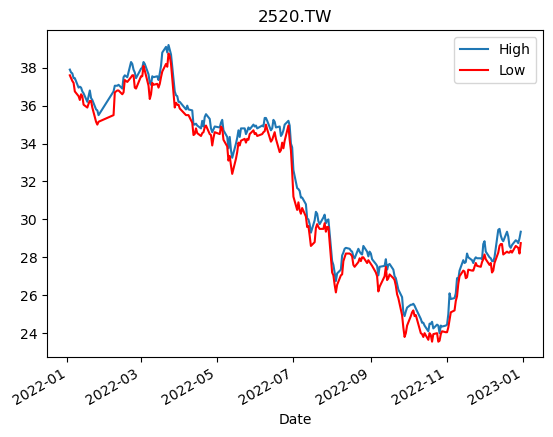

1558
[*********************100%***********************]  1 of 1 completed
          Date   Open   High    Low  Close   Adj Close  Volume
0   2022-01-03  146.5  146.5  145.5  146.0  137.179626   49138
1   2022-01-04  146.0  146.5  146.0  146.5  137.649414   28609
2   2022-01-05  146.0  146.0  145.0  146.0  137.179626   34525
3   2022-01-06  146.0  146.0  145.0  146.0  137.179626   47000
4   2022-01-07  145.5  145.5  144.5  145.0  136.240036   48006
..         ...    ...    ...    ...    ...         ...     ...
241 2022-12-26  120.0  121.0  119.5  120.0  120.000000   17001
242 2022-12-27  119.5  120.5  119.0  120.0  120.000000   51304
243 2022-12-28  120.0  120.0  118.5  119.0  119.000000   62009
244 2022-12-29  118.0  119.0  115.5  118.5  118.500000  184575
245 2022-12-30  117.5  120.0  117.5  119.0  119.000000   96140

[246 rows x 7 columns]


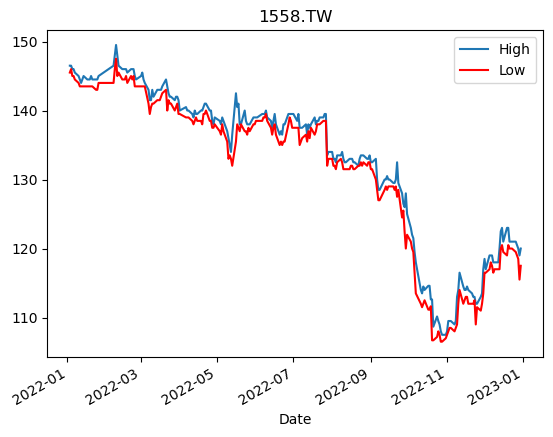

6216
[*********************100%***********************]  1 of 1 completed
          Date       Open       High        Low      Close  Adj Close  Volume
0   2022-01-03  27.950001  28.299999  27.700001  27.799999  26.374226  233000
1   2022-01-04  28.000000  28.000000  27.650000  27.700001  26.279356  190150
2   2022-01-05  27.700001  27.799999  27.500000  27.500000  26.089613  155298
3   2022-01-06  27.500000  27.500000  27.150000  27.450001  26.042177  128100
4   2022-01-07  27.450001  27.450001  26.900000  27.100000  25.710127  363020
..         ...        ...        ...        ...        ...        ...     ...
241 2022-12-26  25.250000  25.450001  25.200001  25.250000  25.250000  165457
242 2022-12-27  25.250000  25.400000  25.250000  25.400000  25.400000  104100
243 2022-12-28  25.299999  25.299999  25.200001  25.250000  25.250000  100292
244 2022-12-29  25.200001  25.250000  25.000000  25.100000  25.100000  158002
245 2022-12-30  25.150000  25.200001  25.100000  25.200001  25.20000

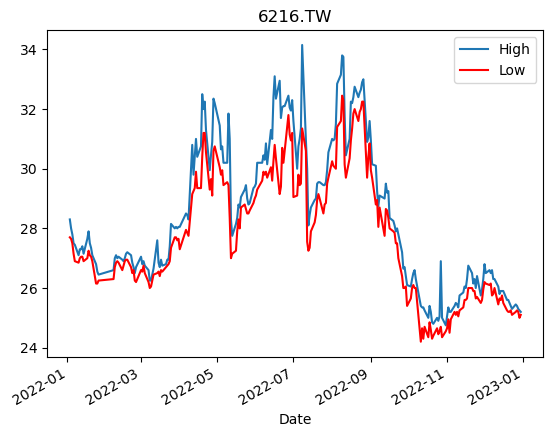

8222
[*********************100%***********************]  1 of 1 completed
          Date       Open       High        Low      Close  Adj Close   Volume
0   2022-01-03  14.850000  14.950000  14.850000  14.900000  14.900000    74030
1   2022-01-04  15.000000  15.000000  14.800000  14.850000  14.850000    68014
2   2022-01-05  14.800000  14.900000  14.800000  14.850000  14.850000    64042
3   2022-01-06  14.850000  15.000000  14.800000  14.950000  14.950000    70101
4   2022-01-07  14.900000  14.950000  14.700000  14.800000  14.800000   201100
..         ...        ...        ...        ...        ...        ...      ...
241 2022-12-26  27.299999  27.850000  26.000000  26.500000  26.500000  8558684
242 2022-12-27  27.000000  27.500000  26.299999  26.299999  26.299999  4577103
243 2022-12-28  26.500000  26.900000  25.250000  25.400000  25.400000  4098991
244 2022-12-29  25.299999  25.799999  25.250000  25.400000  25.400000  2118042
245 2022-12-30  25.600000  27.200001  25.400000  26.00000

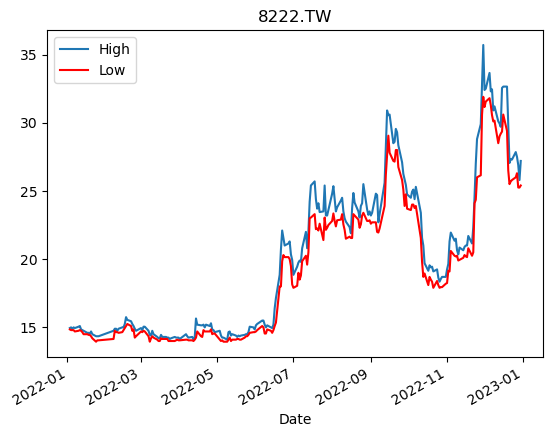

2514
[*********************100%***********************]  1 of 1 completed
          Date       Open       High        Low      Close  Adj Close  Volume
0   2022-01-03  17.750000  17.850000  17.549999  17.650000  17.650000   67086
1   2022-01-04  17.600000  17.650000  17.549999  17.600000  17.600000   36200
2   2022-01-05  17.400000  17.549999  17.400000  17.450001  17.450001   48380
3   2022-01-06  17.600000  17.600000  17.450001  17.500000  17.500000  539185
4   2022-01-07  17.650000  17.650000  17.500000  17.500000  17.500000   63121
..         ...        ...        ...        ...        ...        ...     ...
241 2022-12-26  16.799999  16.950001  16.799999  16.799999  16.799999   56001
242 2022-12-27  16.799999  16.850000  16.700001  16.799999  16.799999  137063
243 2022-12-28  16.750000  17.100000  16.700001  16.700001  16.700001  207061
244 2022-12-29  16.700001  16.700001  16.500000  16.700001  16.700001  121480
245 2022-12-30  16.700001  16.799999  16.650000  16.799999  16.79999

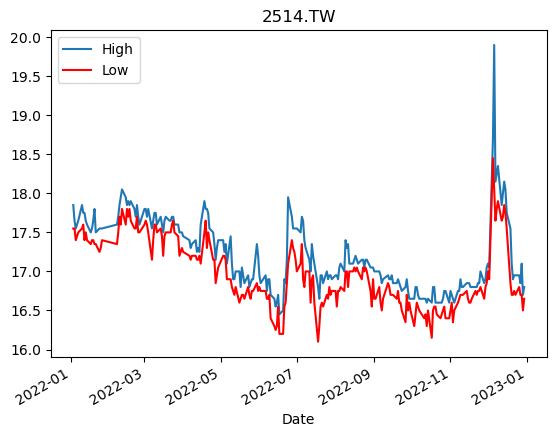

2483
[*********************100%***********************]  1 of 1 completed
          Date       Open       High        Low      Close  Adj Close   Volume
0   2022-01-03  26.600000  26.950001  26.000000  26.100000  25.030329  1084100
1   2022-01-04  26.250000  26.400000  25.799999  25.850000  24.790573   467223
2   2022-01-05  25.850000  26.350000  25.700001  25.850000  24.790573   419025
3   2022-01-06  26.400000  26.600000  26.100000  26.299999  25.222130   616321
4   2022-01-07  26.299999  26.299999  25.549999  25.600000  24.550819   563707
..         ...        ...        ...        ...        ...        ...      ...
241 2022-12-26  24.750000  24.750000  24.049999  24.200001  24.200001    87200
242 2022-12-27  24.400000  24.450001  24.200001  24.250000  24.250000    63000
243 2022-12-28  24.400000  24.400000  23.850000  23.900000  23.900000   156089
244 2022-12-29  23.900000  24.250000  23.700001  24.049999  24.049999   149000
245 2022-12-30  24.200001  24.200001  24.000000  24.00000

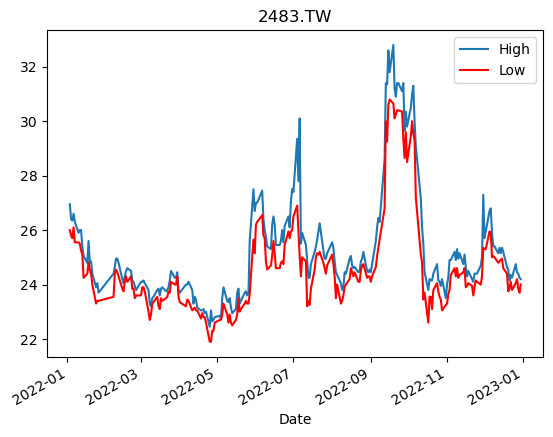

In [48]:
data_quantity = Download_csv('https://www.twse.com.tw/exchangeReport/STOCK_DAY_ALL?response=open_data')  # https://data.gov.tw/dataset/11549
#data_quantity = pd.read_csv('STOCK_DAY_ALL_20221227.csv', encoding = 'UTF-8')
data_quantity.drop(['證券名稱','收盤價','成交金額','成交筆數'], axis=1, inplace = True)
data_quantity.rename(columns = dic, inplace = True)
data_quantity.insert(0,'Date',date)
collect = Link2db('mongodb://localhost:27017/', 'Test', 'Quantity')
Insert(collect, data_quantity)
Update(collect)
Delete(collect)

df = Readdb(collect,days=1)
df.drop(['index'], axis=1, inplace=True)
df = df.sort_values(by=['Quantity'], ascending=False).reset_index()

for i in range(10):
    print(df['Number'].iloc[i])
    Plot(df['Number'].iloc[i], saving = True) # saving = True


In [15]:
merge = pd.merge(data_price, data_quantity, on=['Number','Date'], how='inner')
#merge.to_csv('test.csv', index=False, encoding = 'UTF-8')
merge = merge.loc[:,['Date','Number','Price','Price_month','Quantity','Start','High','Low','Spread']]
print(merge)

0           Date Number   Price Price_month Quantity   Start    High     Low  \
0     2022-12-31   0050  110.20      113.20  8890361  110.60  110.75  110.20   
1     2022-12-31   0051   51.25       52.22    12168   51.55   51.55   51.25   
2     2022-12-31   0052   92.50       96.21   112421   93.50   93.60   92.50   
3     2022-12-31   0053   51.40       54.00     7129   52.35   52.40   51.40   
4     2022-12-31   0055   21.50       21.72   239362   21.45   21.58   21.44   
...          ...    ...     ...         ...      ...     ...     ...     ...   
1173  2022-12-31   9944   20.45       20.47    58726   20.45   20.50   20.35   
1174  2022-12-31   9945   43.25       44.47  4756058   43.25   43.50   42.90   
1175  2022-12-31   9946   12.20       12.25    13462   12.20   12.20   12.20   
1176  2022-12-31   9955   19.80       20.60   174902   20.30   20.30   19.80   
1177  2022-12-31   9958   88.60       88.10  4649425   90.90   91.20   88.60   

0      Spread  
0      0.7000  
1      

In [16]:
com = Download_csv('https://mopsfin.twse.com.tw/opendata/t187ap03_L.csv') # https://data.gov.tw/dataset/18419
#com = pd.read_csv('t187ap03_L.csv', encoding = 'UTF-8') 
com.rename(columns = dic, inplace = True)
com['Number'] = com['Number'].apply(str)
com = com.loc[:,['Number','公司名稱','公司簡稱','住址','營利事業統一編號','董事長','過戶電話','過戶地址','傳真機號碼','電子郵件信箱','網址']]
print(com)
collect = Link2db('mongodb://localhost:27017/', 'Test', 'Company')
Insert(collect, com, False)

0   Number              公司名稱  公司簡稱                      住址  營利事業統一編號  董事長  \
1     1101        臺灣水泥股份有限公司    台泥           台北市中山北路2段113號  11913502  張安平   
2     1102        亞洲水泥股份有限公司    亞泥  台北市大安區敦化南路2段207號30、31樓  03244509  徐旭東   
3     1103        嘉新水泥股份有限公司    嘉泥            台北市中山北路2段96號  11892801  張剛綸   
4     1104        環球水泥股份有限公司    環泥        台北市南京東路二段125號10樓  07568009  侯博義   
5     1108        幸福水泥股份有限公司    幸福           台北市松江路237號15樓  40601248  陳兩傳   
..     ...               ...   ...                     ...       ...  ...   
977   9944        新麗企業股份有限公司    新麗            桃園市八德區聯華街41號  33375909  簡瑞瑞   
978   9945      潤泰創新國際股份有限公司   潤泰新       台北市八德路二段三０八號十一樓之一  12139612  簡滄圳   
979   9946  三發地產股份有限公司(原:金革)  三發地產       台北市松山區八德路3段30號12樓  84466749  鍾鼎晟   
980   9955      佳龍科技工程股份有限公司    佳龍      桃園市觀音區大潭里一鄰環科路323號  97211972  吳界欣   
981   9958      世紀鋼鐵結構股份有限公司   世紀鋼        桃園市觀音區中山路一段1119號  22649001  賴文祥   

0             過戶電話                   過戶地址          傳真機號碼  \
1         66365

In [121]:
data = pd.merge(merge, com, on="Number", how='inner')
print(data)
data.to_csv('data.csv', index=False, encoding = 'UTF-8')
collect = Link2db('mongodb://localhost:27017/', 'Test', 'demo')
#Insert(collect, data)

0          Date Number  Price Price_month Quantity  Start   High    Low  \
0    2022-12-31   1101  33.65       33.85  8560973  33.90  34.00  33.65   
1    2022-12-31   1102  41.00       41.16  2299567  40.90  41.10  40.70   
2    2022-12-31   1103  17.40       17.68    54327  17.50  17.50  17.40   
3    2022-12-31   1104  22.20       22.38   180592  22.25  22.25  22.00   
4    2022-12-31   1108  10.75       10.85    33013  10.80  10.80  10.75   
..          ...    ...    ...         ...      ...    ...    ...    ...   
973  2022-12-31   9944  20.45       20.47    58726  20.45  20.50  20.35   
974  2022-12-31   9945  43.25       44.47  4756058  43.25  43.50  42.90   
975  2022-12-31   9946  12.20       12.25    13462  12.20  12.20  12.20   
976  2022-12-31   9955  19.80       20.60   174902  20.30  20.30  19.80   
977  2022-12-31   9958  88.60       88.10  4649425  90.90  91.20  88.60   

0     Spread              公司名稱  公司簡稱                      住址  營利事業統一編號  董事長  \
0    -0.0500        